# Train a Custom Object Detector using YOLOv5

In this notebook, you will learn how to train a YOLOv5 object detection model on a custom dataset. We will be training YOLOv5 *medium* model to detect **Mask-No_Mask**. The steps involved in training process are as follows.

1. Setting up dependencies
2. Dataset preparation
3. Visualization
4. Training
5. Inference

## Import Dependencies

In [34]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

The dataset is structured in the following manner:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```
The `labels` directory contains `label.txt` files that consists of annotation data. YOLOv5 Pytorch normalised format is as follows.

```
class_label   center_x   center_y   width   height

0 0.5132211538461539 0.6069711538461539 0.9591346153846154 0.4795673076923077
```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset. The Drone dataset contains 1 class: **'Mask-No_Mask'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
test: ../test/images
val: ../valid/images

nc: 2
names: ['mask', 'no_mask']
```

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [35]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2 
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax 


In [36]:
class_names = ['mask', 'no_mask']

The following function `plot_box()` renders bounding box around the objects according to the annotated data.

In [37]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize the bounding box coordinates.
    h, w = image.shape[:2]

    for box_num, box in enumerate(bboxes):
        # Obtain top_left and bottom_right corners.
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        # Width and height of the bounding box.
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        # Render bounding box around the object.
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0,0,255), thickness=max(2, int(w/275))) 

        # Render labels.
        font_scale = min(1, max(4,int(w/500)))
        font_thickness = min(1, max(10,int(w/50)))
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        # Text width and height.
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]

        p2 = p1[0] + tw, p1[1] + -th - 10

        cv2.rectangle(image, p1, p2, color=(255,0,0), thickness=-1)
        cv2.putText(image, class_name, (xmin+1, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return image


### Function to visualize random images with the bounding boxes


In [38]:
def visualize(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(20, 17))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()
    

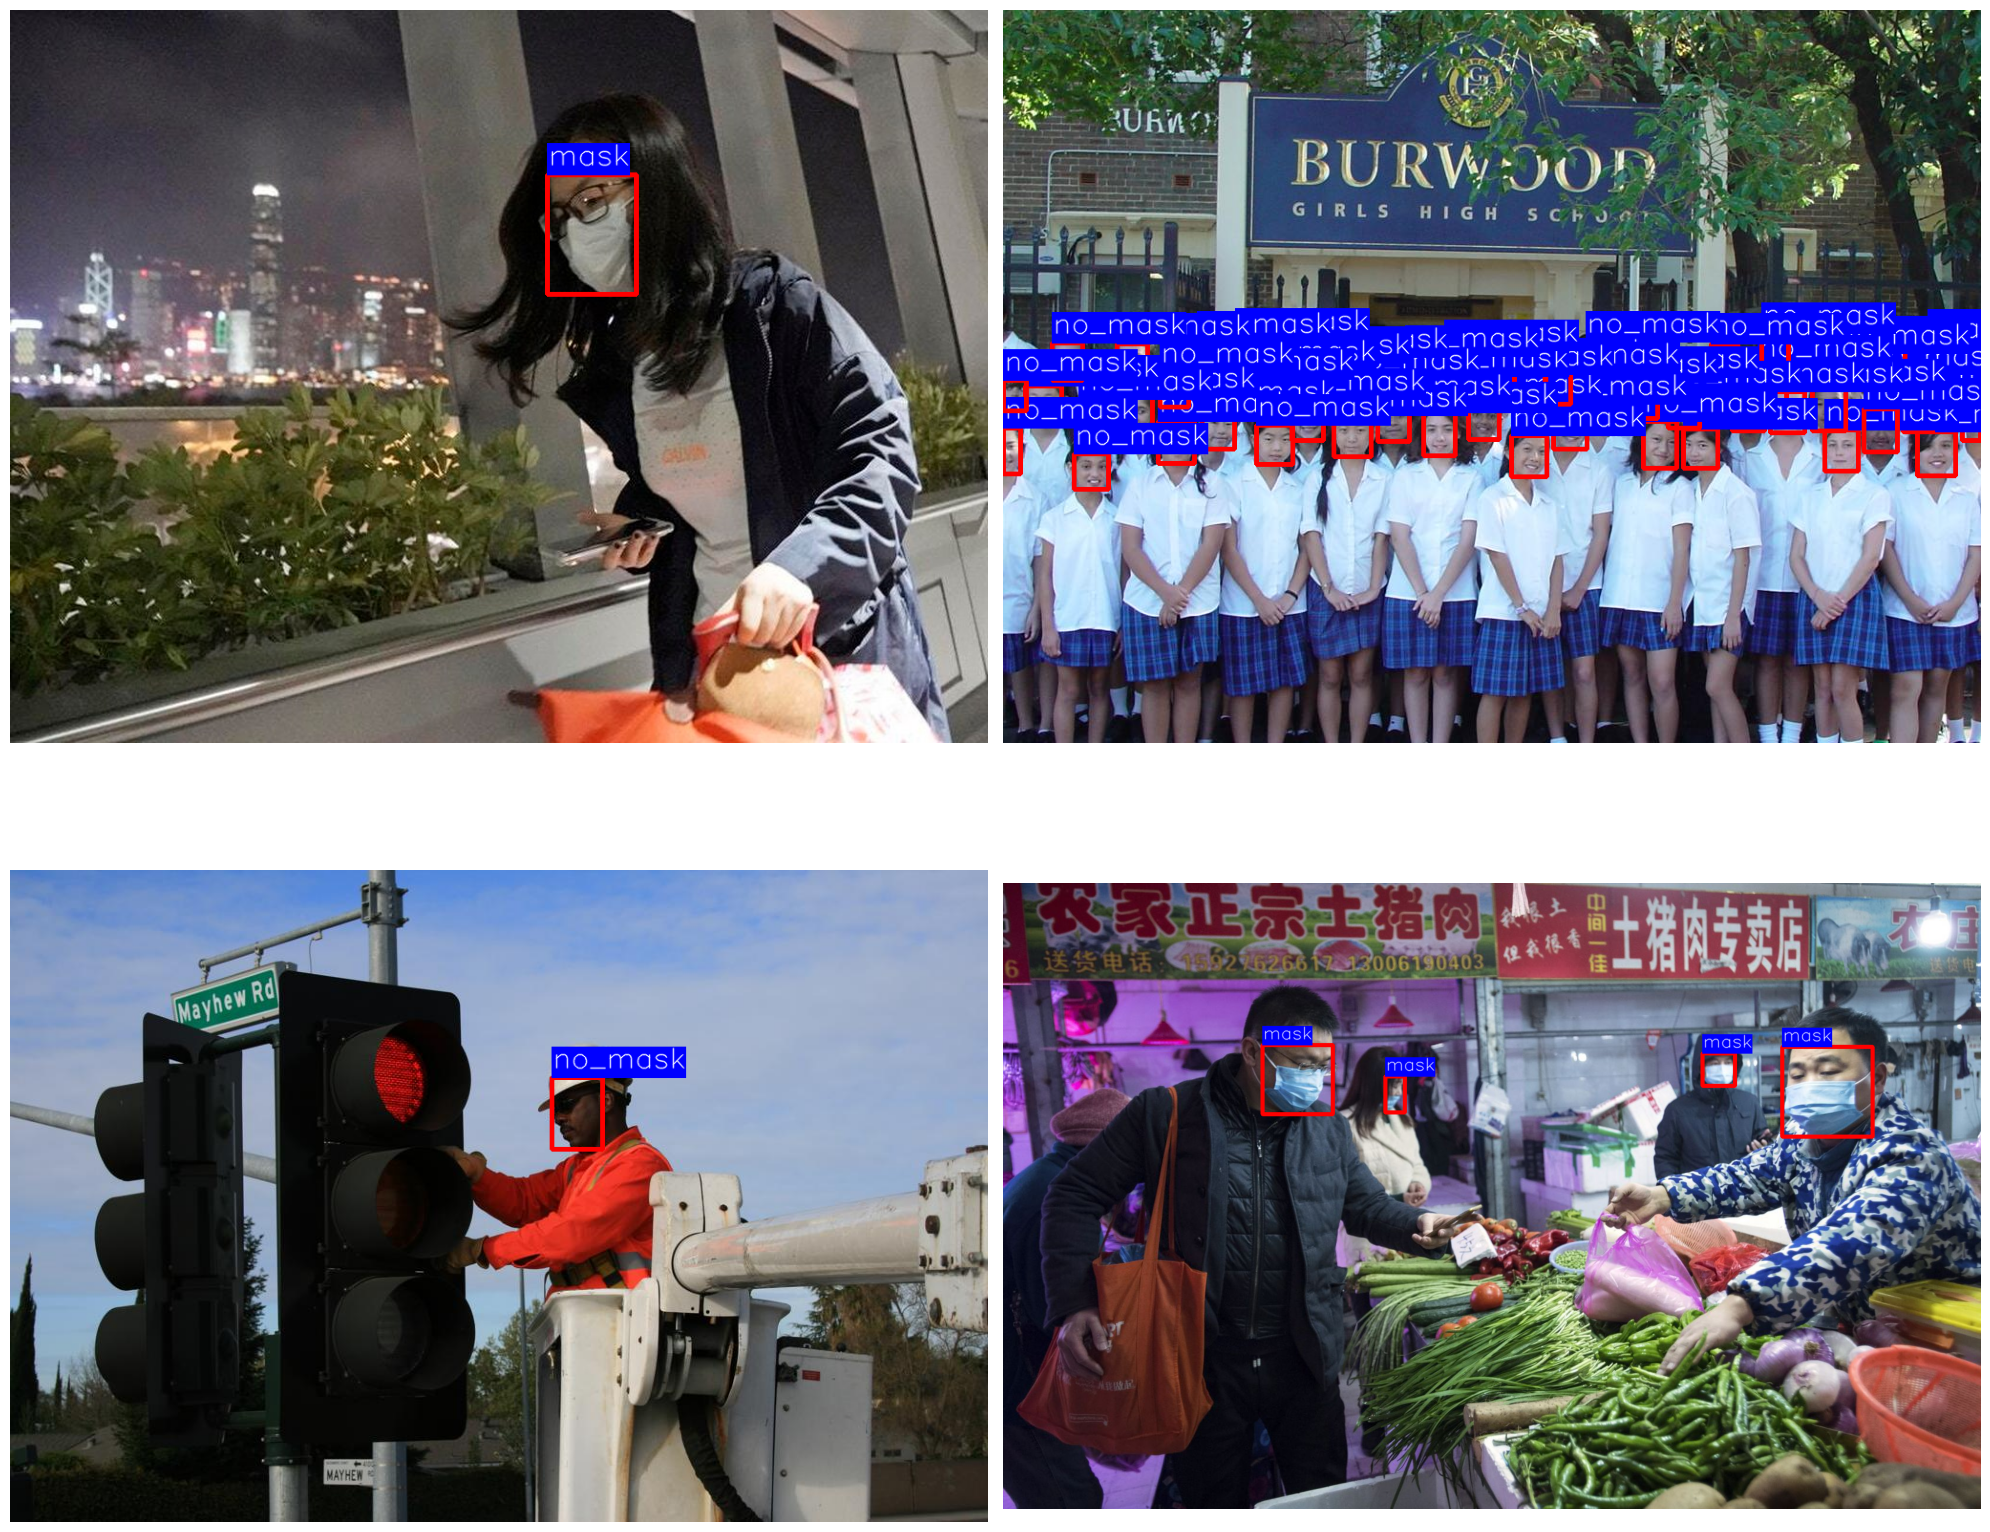

In [39]:
# Visualize a few training images.
visualize(
    image_paths='C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/mask_no-mask_dataset/images/*', 
    label_paths='C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/mask_no-mask_dataset/labels/*',
    num_samples=4,
)


## Clone YOLOV5 Repository

In [40]:
if not os.path.exists('C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [41]:
!cd C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5
!cd

c:\Users\ADMIN\Documents\Python\Train_Yolo_Mask_NoMask


In [42]:
!pip install -r C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/requirements.txt

## Training using YOLOV5

The next step is to train the neural network model. Here, we are going to train YOLOv5 medium model.

* As we have already mentioned above, `data.yaml` file contains information about the data path and labels. It has to be specifically mentioned through `--data` flag that we are using custom dataset. 

* The flag `--weights` specify the model that we are going to use for Transfer learning. If the model is not present in the root directory, YOLOv5 will download it automatically.

* The flag `--img` is used to specify the size of the training or validation image. The images are resized to the specified size before training. You can also use `--imgsz` or `--img-size`. All of them serve the same purpose. The size should be a multiple of 32.

* You can play with total number of training epochs and observe how mAP improves.

* The flag `--batch-size` says how many images to be processed at once.



In [43]:
!python C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/train.py --weights C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/yolov5s.pt --cfg C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/models/yolov5s.yaml --data C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/data.yaml --hyp C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/data/hyps/hyp.scratch-low.yaml --epochs 50 --batch-size 16 --imgsz 640 --rect --project runs/train --name yolov5s_results

## Testing

In [44]:
!python "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/val.py" --task "val" --weights "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt" --data "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/data.yaml"

## Inference
In this section, we will carry out inference on unseen images and videos from the internet. Note that the `inferece_results` folder will change with every run. Make sure to change the path if you are running the block more than once.

In [51]:
# detect images
!python "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/detect.py" --source "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/ThuNghiem" --weights "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt" --project inference_results --name . 

requirements: C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\requirements.txt not found, check failed.


detect: weights=['C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt'], source=C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/ThuNghiem, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=inference_results, name=., exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-168-gec2b853 Python-3.11.3 torch-2.0.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 C:\Users\ADMIN\Documents\Python\Train_Yolo_Mask_NoMask\ThuNghiem\test-image1.jpg: 640x448 1 mask, 220.1ms
image 2/8 C:\Users\ADMIN\Documents\Python\Train_Yolo_Mask_NoMask\ThuNghiem\test-image2.jpg: 448x640 4 masks, 1 no_mask, 253.1ms
imag

In [1]:
#!python "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/detect.py" --source 0 --weights "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt" --project inference_results --name .


requirements: C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\requirements.txt not found, check failed.


detect: weights=['C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt'], source=0, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=inference_results, name=., exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-168-gec2b853 Python-3.11.3 torch-2.0.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
1/1: 0...  Success (inf frames 640x480 at 30.00 FPS)

0: 480x640 1 no_mask, 267.0ms
0: 480x640 1 no_mask, 262.5ms
0: 480x640 1 no_mask, 335.7ms
0: 480x640 1 no_mask, 237.7ms
0: 480x640 1 no_mask, 261.7ms
0: 480x640 1 no_mask, 233.7ms
0: 480x640 1 no_mask, 209.2ms
0: 480x640 1 no_mask, 223.6ms
0: 480x640 1 no_m

In [47]:
#detect video
#!python "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/detect.py" --source "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/ThuNghiem/test-video1.mp4" --weights "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt" --project inference_results --name .

In [48]:
# hiển thị video với đường dẫn: C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/inference_results5/test-video1.mp4
#!python "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/yolov5/utils/plots.py" --source "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/inference_results5/test-video1.mp4" --weights "C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/runs/train/yolov5s_results3/weights/best.pt" --project inference_results --name . --save-txt --save-conf --nosave --classes 0 --agnostic-nms --augment --visualize --hide-labels --hide-conf --line-thickness 2 --exist-ok
    

In [49]:
# import glob
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# def show_images_in_folder(folder_path):
#     image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']  # Valid image extensions

#     # Combine image extensions into a pattern
#     pattern = os.path.join(folder_path, '*.*')

#     # Use glob module to get a list of image files
#     image_files = []
#     for extension in image_extensions:
#         image_files.extend(glob.glob(os.path.join(folder_path, extension)))

#     # Determine the number of subplots dynamically based on the number of images
#     num_images = len(image_files)
#     num_subplots = min(num_images, 4)

#     # Create the subplots and display the images
#     plt.figure(figsize=(20, 17))
#     for i, img_path in enumerate(image_files[:num_subplots]):
#         plt.subplot(2, 2, i+1)
#         plt.imshow(mpimg.imread(img_path))
#         plt.axis('off')

#     plt.show()

# folder_path = 'C:/Users/ADMIN/Documents/Python/Train_Yolo_Mask_NoMask/inference_results3'
# show_images_in_folder(folder_path)


## Download Model


In [50]:
# from google.colab import files
# files.download('runs/train/exp/weights/best.pt')